# Deep Learning Applications: From modeling to Production

In this tutorial i will show step-by-step to create a Deep Learning Application from modeling to production using Keras and Google Cloud ML.

## 1. What is Keras

Keras is a high-level neural networks library, written in Python and capable of running on top of either TensorFlow or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

More information about Keras: https://keras.io/

In this tutorial I will use Keras and Transfer Learning to create an Image Classification API and deploy it to [Google Cloud ML Engine](https://cloud.google.com/ml-engine/).

## 2. Transfer Learning using Keras

**Transfer Learning** is a technique that uses pre-trained neural network and modify some last layers of the network and re-train only the changed parts on a new training data. This network still have ability to extract features of images and can be fine tuned for specific image classification. The advantage is that we need less time and fewer training data to re-train.

Keras already provides us some great [pre-trained models](https://keras.io/applications/) which were trained on a large datasets of ImageNet:

- VGG (Visual Geometry Group at the University of Oxford): Deep NN with either 16 or 19 layers
- ResNet50 (Microsoft Research): This is 50-layer NN
- Inception-v3 (Google)
- Xception (author of Keras)

In this tutorial we gonna use Inception-v3 (I like Google's products :))

### Import required library

In [2]:
import numpy as np
import pandas as pd
import requests

from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from io import BytesIO

Let's try using pre-trained *Inception-v3* model to classify some of the images. Since Inception-v3 model accepts RGB 299x299 images as input, we must preprocess image before classify it. Keras provides us very helful modules to do this.

In [3]:
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(weights='imagenet')

img_path = 'dog-food-test.jpg'
img = image.load_img(img_path, target_size=(299, 299))
x= image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

This is the image:

<img src="dog-food-test.jpg">

This is the predicted classes from the pretrained model:

In [4]:
# Classify the image
preds = model.predict(x)

# Print predicted classes
print('Predicted:')
for p in decode_predictions(preds, top=5)[0]:
    print("Label: {}, Score: {}".format(p[1], p[2]))

Predicted:
Label: can_opener, Score: 0.09016726166009903
Label: nipple, Score: 0.054355572909116745
Label: face_powder, Score: 0.04664556309580803
Label: lotion, Score: 0.04520213231444359
Label: eggnog, Score: 0.04017522558569908


Say we want to classify the image whether it is a dog food or cat food. We will never get results we want by just using the pretrained model. We need to do transfer learning in order to fine tune the model on our data.

### Data Preparation
We have prepared a data for dog food and cat food in numpy array and store it in a npz file. See [this notebook](https://gitlab.com/datasart/datasart-deep-learning/blob/master/datasets/Making_Training_Data_From_ImageNet.ipynb) to know how to prepare the data.

Let's load the data.

In [5]:
dataset = np.load("../datasets/dog_cat_food.npz")
X_dataset = dataset['features']
y_dataset = dataset['labels']

#### Split dataset for tran and test

In [6]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

X_dataset = preprocess_input(X_dataset)
y_dataset = np_utils.to_categorical(y_dataset)

X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

Just to clafify that the pretrained InceptionV3 model cannot predict correcty Dog Food/Cat Food dataset.

In [7]:
x = X_dataset[0]
x = np.expand_dims(x, axis=0)

preds = model.predict(x)
print('Predicted:')
for p in decode_predictions(preds, top=5)[0]:
    print("Label: {}, Score: {}".format(p[1], p[2]))

Predicted:
Label: measuring_cup, Score: 0.18297310173511505
Label: mixing_bowl, Score: 0.14904427528381348
Label: bathtub, Score: 0.0707203820347786
Label: tub, Score: 0.053981516510248184
Label: lumbermill, Score: 0.043141044676303864


### Discover Last Layers of the pretrained InceptionV3

In [8]:
pd.DataFrame(model.layers).tail()

,0
308,<keras.layers.merge.Concatenate object at 0x11...
309,<keras.layers.core.Activation object at 0x11ec...
310,<keras.layers.merge.Concatenate object at 0x11...
311,<keras.layers.pooling.GlobalAveragePooling2D o...
312,<keras.layers.core.Dense object at 0x11ecbbac8>


We want to visualize the *GlobalAveragePooling2D* layer, we construct a model to ouput the intermediate layer outputs

In [9]:
from keras.models import Model

intermediate_model = Model(inputs=model.input, outputs=model.layers[311].output)

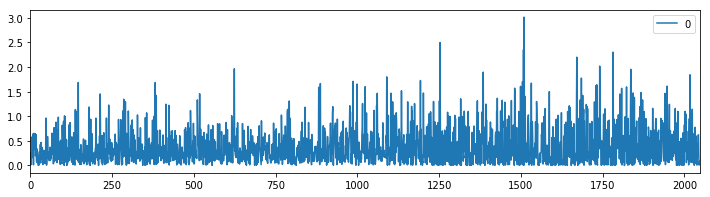

In [10]:
%matplotlib inline
features = intermediate_model.predict(x)
pd.DataFrame(features.reshape(-1,1)).plot(figsize=(12,3))

The output of the *GlobalAveragePooling2D* are 2048 dimession features. Inception-V3 model classifies 1000 classes by using Dense layer at the end of the network, which use these feature as input. Now, we want to classiy "Dog Food/Cat Food" classes. We need to remove the last layer and add another Dense layer.

In [11]:
from keras.layers import Dense

x = intermediate_model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x) # This now become last layer of our model

transfer_model = Model(inputs=intermediate_model.input, outputs=predictions)

For fine tune, we do not want to re-train all layers of the network, we only want to train the new Dense layer added. We can do this by freeze the layers of intermidiate model:

In [12]:
for layer in transfer_model.layers:
    layer.trainable = False
# Unfreeze two last layers
transfer_model.layers[312].trainable = True
transfer_model.layers[313].trainable = True

#### Compile the transfer model

In [13]:
transfer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Re-train the model

In [14]:
transfer_model.fit(X_train, y_train, 
                   epochs=20, verbose=2, 
                   validation_data=(X_test, y_test))

Train on 160 samples, validate on 40 samples
Epoch 1/20
120s - loss: 2.2711 - acc: 0.4875 - val_loss: 2.1234 - val_acc: 0.4750
Epoch 2/20
106s - loss: 0.9743 - acc: 0.5438 - val_loss: 0.8655 - val_acc: 0.5250
Epoch 3/20
113s - loss: 0.6459 - acc: 0.6375 - val_loss: 0.7689 - val_acc: 0.5750
Epoch 4/20
114s - loss: 0.6706 - acc: 0.5438 - val_loss: 0.5571 - val_acc: 0.7000
Epoch 5/20
122s - loss: 0.5312 - acc: 0.8250 - val_loss: 0.5246 - val_acc: 0.8000
Epoch 6/20
115s - loss: 0.4918 - acc: 0.8625 - val_loss: 0.5216 - val_acc: 0.7000
Epoch 7/20
119s - loss: 0.4392 - acc: 0.8438 - val_loss: 0.4551 - val_acc: 0.7500
Epoch 8/20
106s - loss: 0.4149 - acc: 0.8563 - val_loss: 0.5515 - val_acc: 0.6500
Epoch 9/20
116s - loss: 0.3684 - acc: 0.8812 - val_loss: 0.4453 - val_acc: 0.7750
Epoch 10/20
110s - loss: 0.3567 - acc: 0.8812 - val_loss: 0.4595 - val_acc: 0.8000
Epoch 11/20
108s - loss: 0.2648 - acc: 0.9375 - val_loss: 0.4419 - val_acc: 0.7250
Epoch 12/20
103s - loss: 0.2851 - acc: 0.8750 - val

#### Evaluate the model

In [31]:
loss, acc = transfer_model.evaluate(X_test, y_test)
print('Loss: {}, Accuracy: {}'.format(loss, acc))

40/40 [==============================] - 24s    
Loss: 0.5231947183609009, Accuracy: 0.725


Clearly we have a variance problem, we need to get more training data for our model. For this tutorial we gonna use this trained model.

#### Make prediction

In [20]:
img_path = 'dog-food-test.jpg'
img = image.load_img(img_path, target_size=(299, 299))
x= image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = transfer_model.predict(x)
print(preds)

[[ 0.99878365  0.00121639]]


Our fine tuned model predict the above image is a dog food which is a correct prediction.

Now we have created and trained a model that can predict an image is dog food or cat food. Let's deploy this model to Google Cloud. Deploy the model to Google Cloud help us to scale it up in production to serve lots of users.

## 3. Deploy Model to Google Cloud

We can upload our model to Google Cloud, Google Cloud ML Engine will serve our model, accept prediction requests by REST API, and do auto scalling as well.

### Build a graph that converts image
Since Keras model accepts only raw image array as input, we should convert image format to raw image array.

In [33]:
import tensorflow as tf
from tensorflow.python.framework import graph_util
from keras import backend as K


sess = K.get_session()

from tensorflow.python.framework import graph_util

# Make GraphDef of Transfer Model
g_trans = sess.graph
g_trans_def = graph_util.convert_variables_to_constants(sess,
                                                        g_trans.as_graph_def(),
                                                        [transfer_model.output.name.replace(':0','')])

# Image Converter Model
with tf.Graph().as_default() as g_input:
    input_b64 = tf.placeholder(shape=(1,), dtype=tf.string, name='input')
    input_bytes = tf.decode_base64(input_b64[0])
    image = tf.image.decode_image(input_bytes)
    image_f = tf.image.convert_image_dtype(image, dtype=tf.float32)
    input_image = tf.expand_dims(image_f, 0)
    output = tf.identity(input_image, name='input_image')

g_input_def = g_input.as_graph_def()



with tf.Graph().as_default() as g_combined:
    x = tf.placeholder(tf.string, name="input_b64")

    im, = tf.import_graph_def(g_input_def,
                              input_map={'input:0': x},
                              return_elements=["input_image:0"])

    pred, = tf.import_graph_def(g_trans_def,
                                input_map={transfer_model.input.name: im,
                                          'batch_normalization_1/keras_learning_phase:0': False},
                                return_elements=[transfer_model.output.name])

    with tf.Session() as sess2:
        inputs = {"inputs": tf.saved_model.utils.build_tensor_info(x)}
        outputs = {"outputs": tf.saved_model.utils.build_tensor_info(pred)}
        signature = tf.saved_model.signature_def_utils.build_signature_def(
            inputs=inputs,
            outputs=outputs,
            method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
        )

        # save as SavedModel
        b = tf.saved_model.builder.SavedModelBuilder('exported_model')
        b.add_meta_graph_and_variables(sess2,
                                       [tf.saved_model.tag_constants.SERVING],
                                       signature_def_map={'serving_default': signature})
        b.save()

INFO:tensorflow:Froze 380 variables.
Converted 380 variables to const ops.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'exported_model/saved_model.pb'


We just exported the model to *exported_model* folder. This folder contains *saved_model.pb* file, this file contains the structure of our model in Google's protobuf format. There's alseo a variable sub-folder that cntains a checkpoint of the train weights from our NN network. Now the model is ready to upload Google Cloud.

### Configure a Google Cloud Project

Next we need to create a project on [Google Cloud Platform](https://console.cloud.google.com) to host our model. This can be easily done from the Google Cloud platform dashboard. Let's name this project "Deep Learning". From here you can access all the different Google Cloud services. In order to run our model in Google Cloud we need to enable Google Cloud Machine Learning service. Let's go to *APIs & Services* menu find Google Cloud ML service and enable it. Once we enable Google Cloud ML service, we are good to upload our model.

We will use the Google Cloud SDK to work with Google Cloud. Go to [https://cloud.google.com/sdk/](https://cloud.google.com/sdk/) to download and learning how to use the SDK. Once you install the SDK, everything is ready to go.

First we need to run the following command to configure google cloud enviroment in our computer:
```
$gcloud init
```

### Uploading our model

Now we are ready to upload our model to google cloud. We use *gsutil* from the SDK to do so.

#### First we need to create a bucket to store our model:
Let's create our *datasart-dl-model* bucket on google cloud
```
gsutil mb -l us-central1 gs://datasart-dl-model
```

#### Next we need to upload our model to the created bucket:
```
gsutil cp -R exported_model/* gs://datasart-dl-model/cat_dog_food_v1/
```

#### Next we have to tell the Google Cloud ML engine that we want to create a new model:
```
gcloud ml-engine models create fooddetector --regions us-central1
```

#### Finally we can create a running version of the model:
```
gcloud ml-engine versions create v1 --model=fooddetector --origin=gs://datasart-dl-model/cat_dog_food_v1/ --runtime-version=1.2
```
This will take several minutes to finish. Once the process is done, we are ready to use the model anywhere.

### Using the model

Now we can call the model from Google Cloud to predict hand written digit whether is six or not six. 

We can use Google API client library to call our model. For Python you can easily install the library with *pip*.

In [1]:
from oauth2client.client import GoogleCredentials
import googleapiclient.discovery

We will need to have a credentials to access our google cloud service. Go to Google Cloud Platform dashboard (APIs & Service -> Credentials) and create a service account key for our project and save it as json file to our local computer.

In [7]:
PROJECT_ID = "deep-learning-180004"
MODEL_NAME = "fooddetector"
CREDENTIALS_FILE = "credentials.json"

In [3]:
# Connect to the Google Cloud ML service
credentials = GoogleCredentials.from_stream(CREDENTIALS_FILE)
service = googleapiclient.discovery.build('ml', 'v1', credentials=credentials)

Let's classify the above image. The converter graph doesn't have any resizing function, we need to resize the image.

In [10]:
with open('dog-food-test_299_299.jpg', 'rb') as f:
    b64_x = f.read()
import base64
import json

name = 'projects/{}/models/{}'.format(PROJECT_ID, MODEL_NAME)
b64_x = base64.urlsafe_b64encode(b64_x)
b64_x = b64_x.decode('utf-8')
input_instance = dict(inputs=b64_x)
input_instance = json.loads(json.dumps(input_instance))
request_body = {"instances": [input_instance]}

request = service.projects().predict(name=name, body=request_body)

try:
    response = request.execute()
except errors.HttpError as err:
    print(err._get_reason())
response

{'predictions': [{'outputs': [0.9978664517402649, 0.0021335373166948557]}]}

This is the response from deployed model. The list "outputs" represents confidece of Dog Food and Cat Food respectively. From the prediction we can see that the model predict the test image is dog food with 99.78% confident.

## 4. Summary

In this tutorial, I have shown a way to create a backend for Deep Learning application by using Keras libarary and Google Cloud ML Engine. Specifically, I've learned:

- How to use pre-trained model with Keras
- How to prepare data for a Deep Learning application
- How to do transfer learning to fine tune a pre-trained model on a specific data
- How to deploy a trained model to Google Cloud to help us scale it up in production to serve many users